## Exploring the Environment

In [1]:
import gym 
env = gym.make('MountainCar-v0')
env.reset()

array([-0.46746124,  0.        ])

In [2]:
print("State space: ", env.observation_space)
print("Action space: ", env.action_space)
print("Observation space low: ", env.observation_space.low)
print("Observatino space high: ", env.observation_space.high)

State space:  Box(2,)
Action space:  Discrete(3)
Observation space low:  [-1.2  -0.07]
Observatino space high:  [0.6  0.07]


In [3]:
print("New state, reward, Reward, Termination: ", env.step(1))

New state, reward, Reward, Termination:  (array([-4.67880283e-01, -4.19044071e-04]), -1.0, False, {})


## Solving the environment

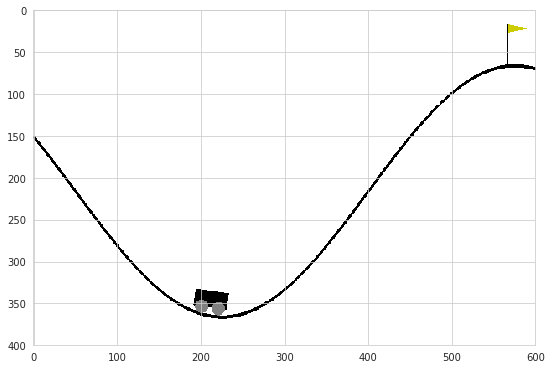

In [6]:
import time
from IPython import display
import numpy as np
import pandas as pd
import gym 
from tqdm import tqdm
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

np.random.seed(2019)

# Import and initialize Mountain Car Envrionment 
env = gym.make("MountainCar-v0")
env.reset()

plt.figure(figsize=(9,9))

img = plt.imshow(env.render(mode='rgb_array'))

In [4]:
def run_training(env, learning_rate, discount, epsilon, min_eps, episodes, monitor_reward_eps=10):
    """
    env: Environment 
    learning rate: learning rate
    discount: discount factor
    epsilon: epsilon value 
    min_epsilon: minimal limit for epsilon value 
    episodes: total_number of episodes
    """
    # Determine size of discretezed state space 
    num_states = (env.observation_space.high - env.observation_space.low) * np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table 
    Q = np.random.uniform(low=-1, high=1, size=(num_states[0], num_states[1], env.action_space.n))
    
    # Initialize variables to track rewards 
    reward_list = []
    avg_reward_list = []
    
    # Calculate episodic reduction in epsilon
    eps_reduction = (epsilon - min_eps) / episodes 
    
    # Run Q-learning algorithm 
    for i_episode in tqdm(range(episodes)):
        reward_total, reward_step = 0, 0
        state = env.reset()
                
        # Discretize space 
        state_discrete = (state - env.observation_space.low) * np.array([10, 100])
        state_discrete = np.round(state_discrete, 0).astype(int)
        
        while True:
            # Render environment for last five episodes 
            #if i_episode == episodes-1:
            #    # Too slow!
            #    plt.imshow(env.render(mode='rgb_array'))
            #    display.display(plt.gcf())
            #    display.clear_output(wait=True)
                
            # Epsilon greedy strategy 
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_discrete[0], state_discrete[1]])
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward 
            next_state, reward_step, done, info = env.step(action)
            
            # Discretize next state 
            next_state_discrete = (next_state - env.observation_space.low) * np.array([10, 100])
            next_state_discrete = np.round(next_state_discrete, 0).astype(int)
            
            # Allow for terminal states 
            if done and next_state[0] >= 0.5:
                Q[state_discrete[0], state_discrete[1], action] = reward_step
            # Update Q-value
            else:
                delta = learning_rate * (reward_step + discount * np.max(Q[next_state_discrete[0], next_state_discrete[1]]) - Q[state_discrete[0], state_discrete[1], action])
                Q[state_discrete[0], state_discrete[1], action] += delta 
                
            # Update variables 
            reward_total += reward_step
            state_discrete = next_state_discrete
            
            if done: break
            
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= eps_reduction
            
        # Track rewards
        reward_list.append(reward_total)
        
        if (i_episode + 1) % monitor_reward_eps == 0:
            avg_reward = np.mean(reward_list)
            avg_reward_list.append(avg_reward)
            reward_list = []
            
    env.close()
        
    return avg_reward_list
    
# Run Q-learning algorithm 
rewards = run_training(env, 0.2, 0.9, 0.8, 0, 10_000)

100%|██████████| 10000/10000 [00:45<00:00, 221.25it/s]


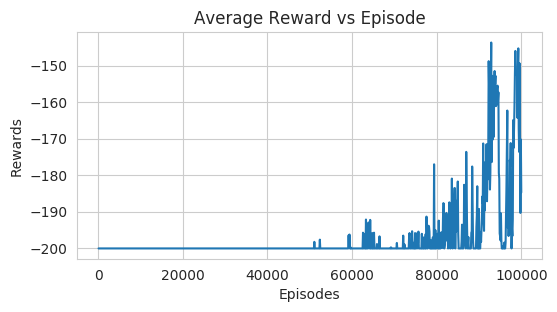

In [5]:
# Plot rewards
plt.figure(figsize=(6, 3), dpi=100)
data = np.array([100 * (np.arange(len(rewards)) + 1), rewards]).T
df = pd.DataFrame(data, columns=['Episodes', 'Rewards'])
plt.title("Average Reward vs Episode")
sns.lineplot(data=df, x='Episodes', y='Rewards')
plt.savefig("reward.jpg")